# FrequencySeries の新機能と高度な操作

このノートブックでは、`gwexpy` で拡張された `FrequencySeries` クラスの新しいメソッドと機能について紹介します。
主に複素スペクトルの扱い、微積分、フィルタリング（スムージング）、および他ライブラリとの連携機能に焦点を当てます。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gwexpy.timeseries import TimeSeries
from gwexpy.frequencyseries import FrequencySeries
from gwexpy.plot import Plot

plt.rcParams['figure.figsize'] = (10, 6)

## 1. データの準備

まずは `TimeSeries` から FFT を用いて `FrequencySeries` を作成します。
ここでは、特定の周波数成分を持つテスト信号を生成します。

TimeSeries([-0.01837386, -0.3828497 ,  0.24309885, ...,
             0.53582706,  0.82070766,  0.69357498]
           unit: um,
           t0: 0.0 s,
           dt: 0.0009765625 s,
           name: Test Signal,
           channel: None)
Type: <class 'gwexpy.frequencyseries.frequencyseries.FrequencySeries'>
Length: 3073
df: 0.16666666666666666 Hz


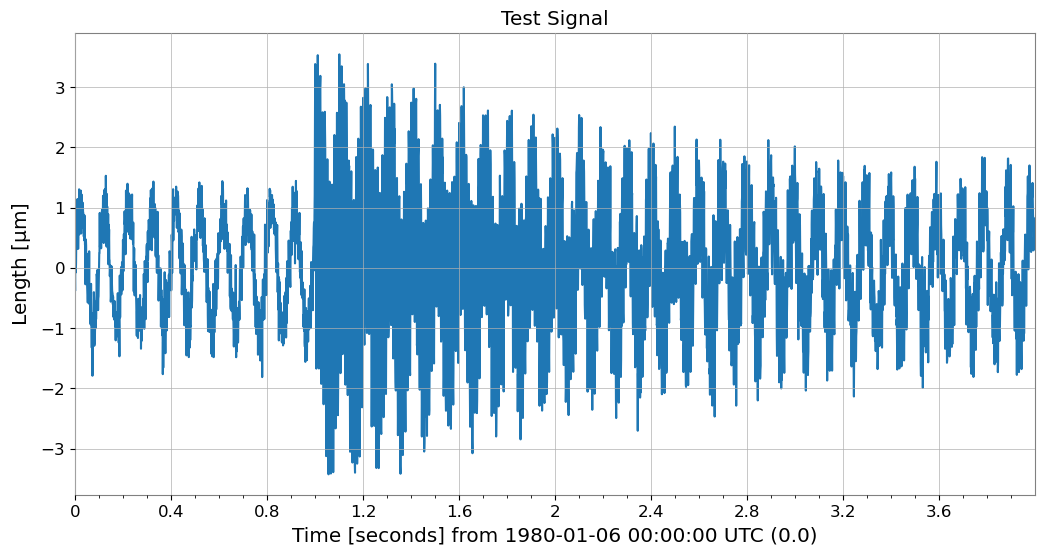

In [2]:
fs = 1024
t = np.arange(0, 4, 1/fs)
exp = np.exp(-t/1.5)
exp[:int(exp.size/4)]=0
data = np.sin(2 * np.pi * 10.1 * t) + 5*exp * np.sin(2 * np.pi * 100.1 * t) + np.random.normal(scale=0.3, size=len(t))
ts = TimeSeries(data, dt=1/fs, unit='um', name='Test Signal')
print(ts)
ts.plot(title=ts.name)

# FFT を実行して FrequencySeries を取得 (transient モードを使用してパディングを適用)
spec = ts.fft(mode="transient", pad_left=1.0, pad_right=1.0, nfft_mode="next_fast_len")
print(f"Type: {type(spec)}")
print(f"Length: {len(spec)}")
print(f"df: {spec.df}")

## 2. 複素スペクトルの可視化と変換

### 位相と振幅
`phase()`, `degree()`, `to_db()` メソッドを使用すると、複素スペクトルを直感的な単位に変換できます。

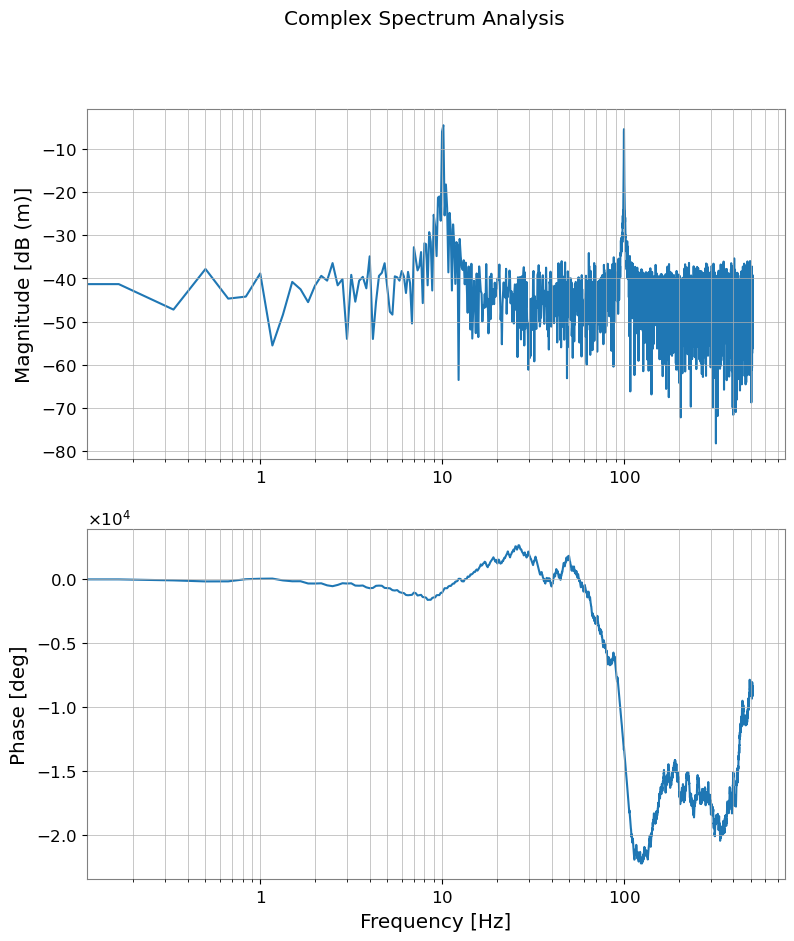

In [3]:
# 振幅を dB に変換 (ref=1.0, 20*log10)
spec_db = spec.to_db()

# 位相を取得 (度数表記、unwrap=True で連続化)
spec_phase = spec.degree(unwrap=True)

plot = Plot(spec_db, spec_phase, separate=True, sharex=True, xscale='log')
ax = plot.axes
ax[0].set_ylabel('Magnitude [dB (m)]')
ax[0].grid(True, which='both')

ax[1].set_ylabel('Phase [deg]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(True, which='both')
plot.figure.suptitle('Complex Spectrum Analysis')
plot.show()

## 3. 周波数ドメインでの微積分

`differentiate()` および `integrate()` メソッドにより、周波数ドメインで微分・積分を行うことができます。
引数 `order` で階数を指定できます（デフォルトは1）。
これは「変位・速度・加速度」の変換（$(2 \pi i f)^n$ の乗算・除算）を簡単に行うための機能です。

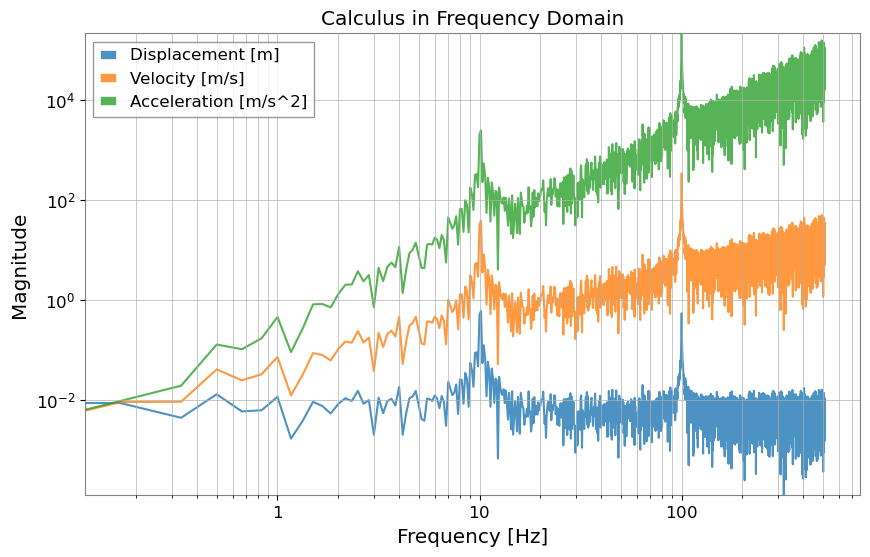

In [4]:
# 変位 (m) -> 速度 (m/s) に微分 (order=1)
vel_spec = spec.differentiate()

# 変位 (m) -> 加速度 (m/s^2) に 2回微分 (order=2)
accel_spec = spec.differentiate(order=2)

# 積分も可能: 加速度 -> 速度
vel_from_accel = accel_spec.integrate()

plot = Plot(spec.abs(), vel_spec.abs(), accel_spec.abs(), xscale='log', yscale='log', alpha=0.8)
ax = plot.gca()
ax.get_lines()[0].set_label('Displacement [m]')
ax.get_lines()[1].set_label('Velocity [m/s]')
ax.get_lines()[2].set_label('Acceleration [m/s^2]')
ax.legend()
ax.grid(True, which='both')
ax.set_title('Calculus in Frequency Domain')
ax.set_ylabel('Magnitude')
plot.show()

## 4. スペクトルのスムージングとピーク検出

### スムージング
`smooth()` メソッドを使用すると、移動平均などによるスペクトルの平滑化が可能です。

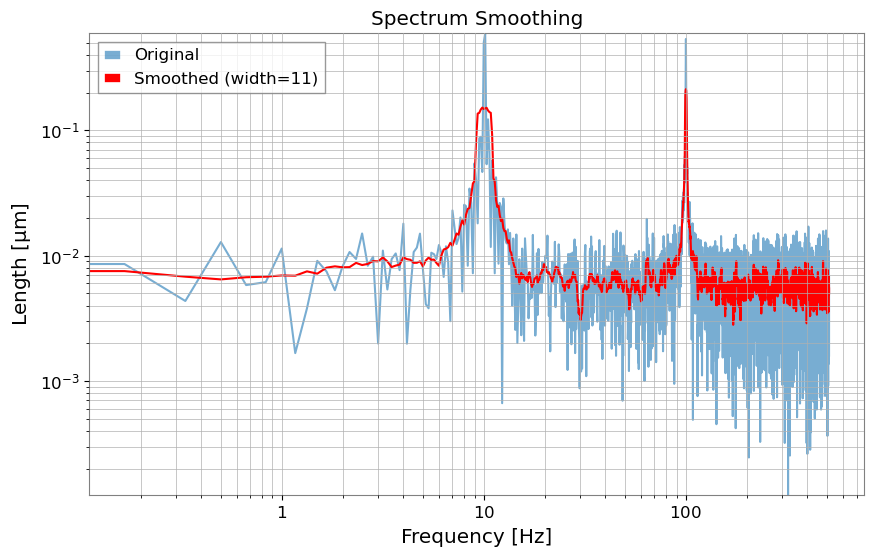

In [5]:
# 振幅ドメインで 11 サンプルのスムージング
spec_smooth = spec.smooth(width=11)

plot = Plot(spec.abs(), spec_smooth.abs(), xscale='log', yscale='log')
ax = plot.gca()
ax.get_lines()[0].set_label('Original')
ax.get_lines()[0].set_alpha(0.6)
ax.get_lines()[1].set_label('Smoothed (width=11)')
ax.get_lines()[1].set_color('red')
ax.legend()
ax.grid(True, which='both')
ax.set_title('Spectrum Smoothing')
plot.show()

### ピーク検出
`find_peaks()` メソッドは `scipy.signal.find_peaks` をラップしており、特定の閾値を超えるピークを簡単に抽出できます。

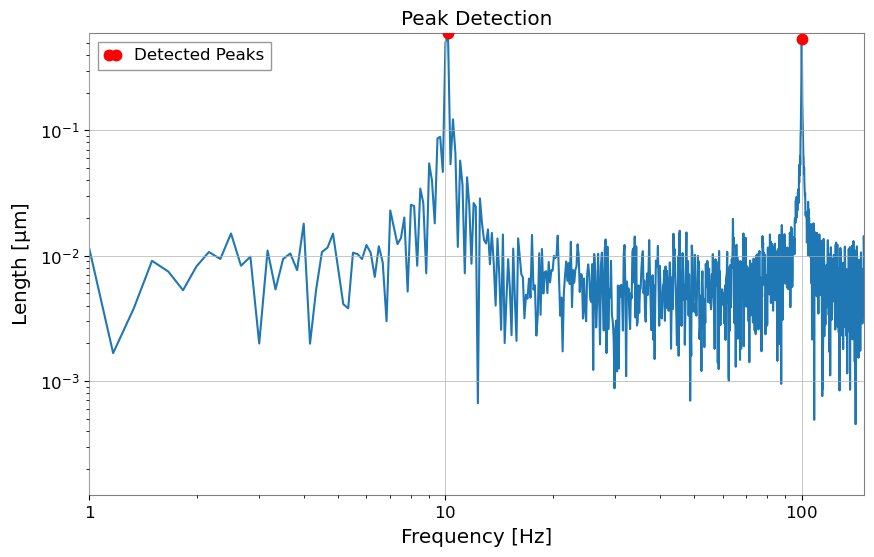

In [6]:
# 振幅 0.2 以上のピークを探す
peaks, props = spec.find_peaks(threshold=0.2)

plot = Plot(spec.abs())
ax = plot.gca()
ax.plot(peaks.abs(), color='red', marker='.',ms=15, lw=0, zorder=3, label='Detected Peaks')
ax.set_xlim(1, 150)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Peak Detection')
ax.legend()
plot.show()

## 5. 高度な解析機能

### 群遅延 (Group Delay)
`group_delay()` メソッドは、位相の周波数微分から群遅延（信号のエンベロープの遅延）を計算します。

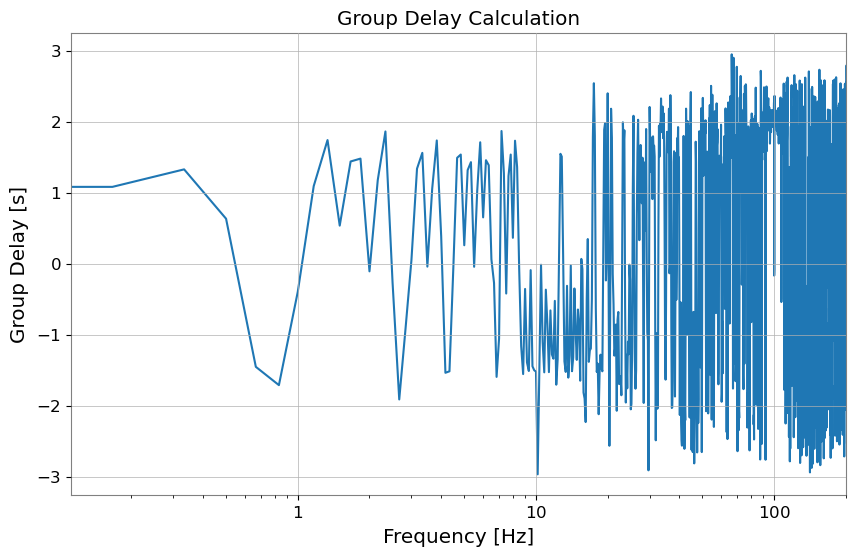

In [7]:
gd = spec.group_delay()

plot = Plot(gd)
ax = plot.gca()
ax.set_ylabel('Group Delay [s]')
ax.set_xlabel('Frequency [Hz]')
ax.set_xlim(0, 200)
ax.set_title('Group Delay Calculation')
plot.show()

### 逆FFT (ifft)
`ifft()` メソッドは、`TimeSeries` を返します。`mode="transient"` で FFT した結果であっても、情報を引き継いで元の長さに戻す (trim=True) などの制御が可能です。

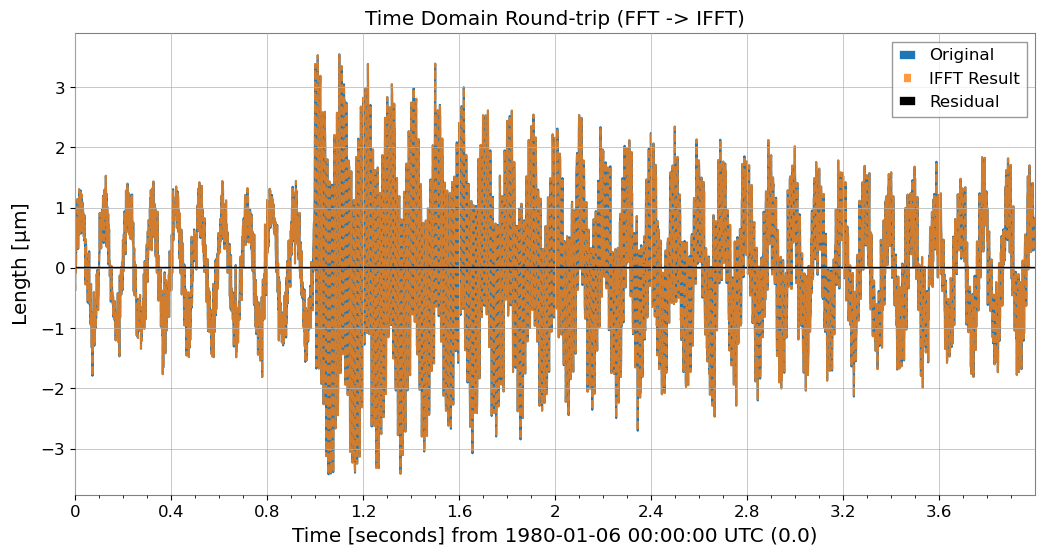

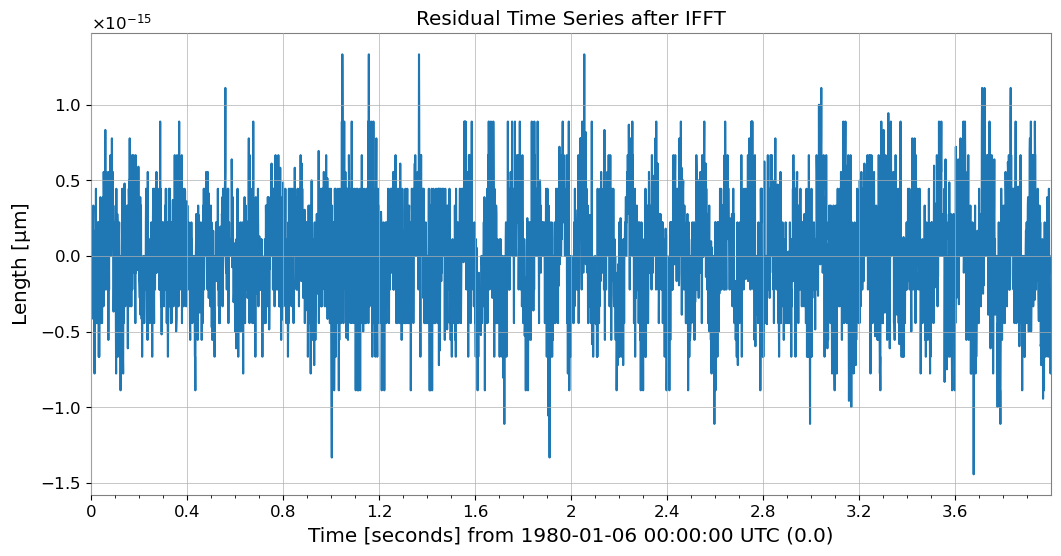

In [8]:
# 逆 FFT で TimeSeries に戻す
# mode="auto" は、入力 FrequencySeries が持つ transient 情報を読み取って適切に処理します
inv_ts = spec.ifft(mode="auto")
red_ts = inv_ts - ts

plot = Plot(ts, inv_ts, red_ts)
ax = plot.gca()
ax.get_lines()[0].set_label('Original')
ax.get_lines()[1].set_label('IFFT Result')
ax.get_lines()[2].set_label('Residual')
ax.get_lines()[1].set_linestyle('--')
ax.get_lines()[1].set_alpha(0.8)
ax.get_lines()[2].set_color('black')
ax.legend()
ax.set_title('Time Domain Round-trip (FFT -> IFFT)')
plot.show()

red_ts.plot(title='Residual Time Series after IFFT');

## 6. 他ライブラリとの連携

Pandas, xarray, control ライブラリとの相互変換が追加されています。

In [9]:
# Pandas Series へ変換
pd_series = spec.to_pandas()
print("Pandas index sample:", pd_series.index[:5])
display(pd_series)

# xarray DataArray へ変換
da = spec.to_xarray()
print("xarray coord name:", list(da.coords))
display(da)

# control.FRD へ変換 (制御系の解析に使用可能)
try:
    from control import FRD
    frd_obj = spec.to_control_frd()
    print("Successfully converted to control.FRD")
    display(frd_obj)
except ImportError:
    print("python-control library not installed")

Pandas index sample: Index([0.0, 0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666], dtype='float64', name='frequency')


frequency
0.000000      0.003575+0.000000j
0.166667      0.005339-0.006711j
0.333333     -0.002794-0.003332j
0.500000     -0.010999+0.006627j
0.666667     -0.005230+0.002564j
                     ...        
511.333333   -0.005343-0.000400j
511.500000   -0.000013+0.005942j
511.666667    0.000057-0.001564j
511.833333   -0.002983-0.002685j
512.000000    0.006740+0.000000j
Name: Test Signal, Length: 3073, dtype: complex128

xarray coord name: ['frequency']


<xarray.DataArray 'Test Signal' (frequency: 3073)> Size: 49kB
array([ 3.57520441e-03+0.j        ,  5.33889108e-03-0.00671101j,
       -2.79383254e-03-0.00333153j, ...,
        5.72659803e-05-0.00156399j, -2.98340640e-03-0.00268503j,
        6.74009222e-03+0.j        ])
Coordinates:
  * frequency  (frequency) float64 25kB 0.0 0.1667 0.3333 ... 511.7 511.8 512.0
Attributes:
    unit:     um
    channel:  None
    epoch:    0.0

Successfully converted to control.FRD


FrequencyResponseData(
array([[[ 3.57520441e-03+0.j        ,
          5.33889108e-03-0.00671101j,
         -2.79383254e-03-0.00333153j, ...,
          5.72659803e-05-0.00156399j,
         -2.98340640e-03-0.00268503j,
          6.74009222e-03+0.j        ]]]),
array([0.00000000e+00, 1.66666667e-01, 3.33333333e-01, ...,
       5.11666667e+02, 5.11833333e+02, 5.12000000e+02]),
outputs=1, inputs=1)

## 7. 位相と群遅延の解析 (Phase & Group Delay)

`FrequencySeries` クラスには、位相 (`phase`, `angle`) や群遅延 (`group_delay`) を計算する便利なメソッドが追加されています。

In [10]:
# 単一チャンネルを取り出す
fs = spec

# 位相の計算 (ラジアン)
phi = fs.phase(unwrap=True)
print("\nUnwrapped Phase (rad) at 10Hz:", phi.value[10])

# 位相の計算 (度)
deg = fs.degree(unwrap=True)
print("Unwrapped Phase (deg) at 10Hz:", deg.value[10])

# 群遅延 (Group Delay) の計算
# Group Delay = -d(phi)/d(omega)
gd = fs.group_delay()
print("\nGroup Delay (s) at 10Hz:", gd.value[10])


Unwrapped Phase (rad) at 10Hz: -3.4307930506270448
Unwrapped Phase (deg) at 10Hz: -196.56996218374223

Group Delay (s) at 10Hz: 1.4410276156925586


## 8. Python Control Library との連携

制御工学の分野で標準的な `control` ライブラリの **Frequency Response Data (FRD)** オブジェクトと相互変換が可能です。
これにより、GWExPyで計測した伝達関数を、制御系の設計や解析に直接利用できます。


--- Converted to Control FRD ---
<FrequencyResponseData>: sys[1]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

Freq [rad/s]  Response
------------  ---------------------
       0.000    0.003575        +0j
       0.167    0.005339 -0.006711j
       0.333   -0.002794 -0.003332j
       0.500      -0.011 +0.006627j
       0.667    -0.00523 +0.002564j
       0.833    0.004927 -0.003675j
       1.000      0.0114-0.0001602j
       1.167    0.001639+0.0003114j
       1.333   -0.002546 -0.002817j
       1.500    -0.00863 +0.002867j
       1.667   -0.007158  +0.00213j
       1.833    0.005198 -0.001039j
       2.000    0.007957 -0.002038j
       2.167     0.01069+0.0002954j
       2.333    -0.00859 -0.003853j
       2.500    -0.01116  +0.01007j
       2.667   -0.004651 -0.006885j
       2.833    0.009734 +0.001271j
       3.000    0.001932-0.0004765j
       3.167     0.01098+0.0002954j
       3.333   -0.005348-0.0005033j
       3.500   -0.009339+0.0009778j
       3.667    -0.01025 -0.001854j
   

/home/washimi/mambaforge/lib/python3.10/site-packages/control/frdata.py:427: FutureWarning: fresp attribute is deprecated; use frdata
  warn("fresp attribute is deprecated; use frdata", FutureWarning)



--- Restored FrequencySeries ---
FrequencySeries([ 3.57520441e-03+0.j        ,
                  5.33889108e-03-0.00671101j,
                 -2.79383254e-03-0.00333153j, ...,
                  5.72659803e-05-0.00156399j,
                 -2.98340640e-03-0.00268503j,
                  6.74009222e-03+0.j        ]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 0.02652582384864922 Hz,
                epoch: None,
                name: None,
                channel: None)


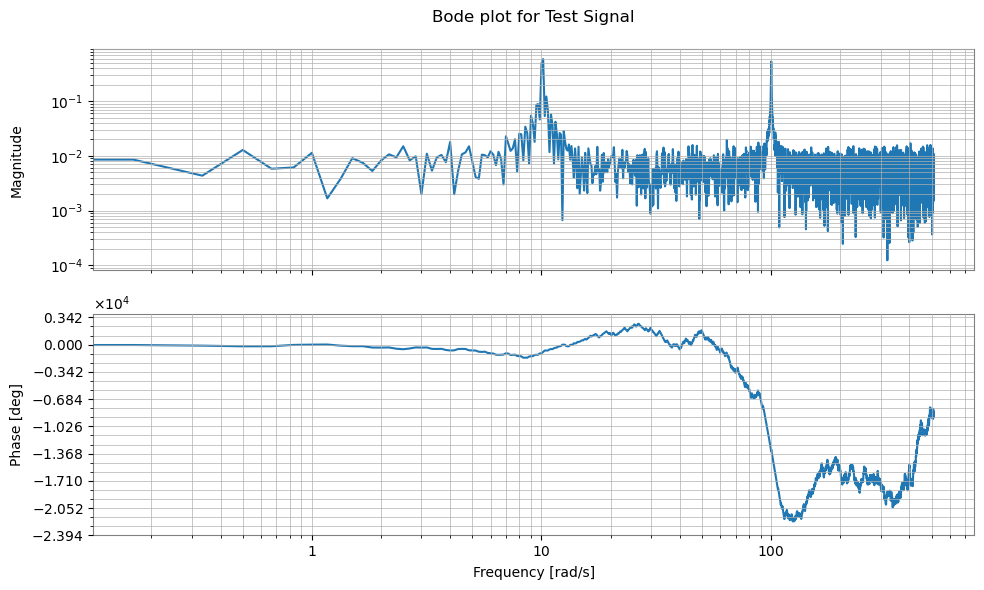

In [11]:
try:
    import control

    # FrequencySeries -> control.FRD 変換
    # frequency_unit="Hz" を指定すると、内部で rad/s に適切に変換して渡します
    frd_sys = fs.to_control_frd(frequency_unit="Hz")

    print("\n--- Converted to Control FRD ---")
    print(frd_sys)

    # ボード線図のプロット (controlライブラリの機能)
    control.bode(frd_sys) # (プロット環境があれば実行可能)

    # control.FRD -> FrequencySeries 復元
    fs_restored = FrequencySeries.from_control_frd(frd_sys, frequency_unit="Hz")

    print("\n--- Restored FrequencySeries ---")
    print(fs_restored)

except ImportError:
    print("Python Control Systems Library is not installed.")

## 9. 求積和 (Quadrature Sum)

直交位相の和を計算する機能です。

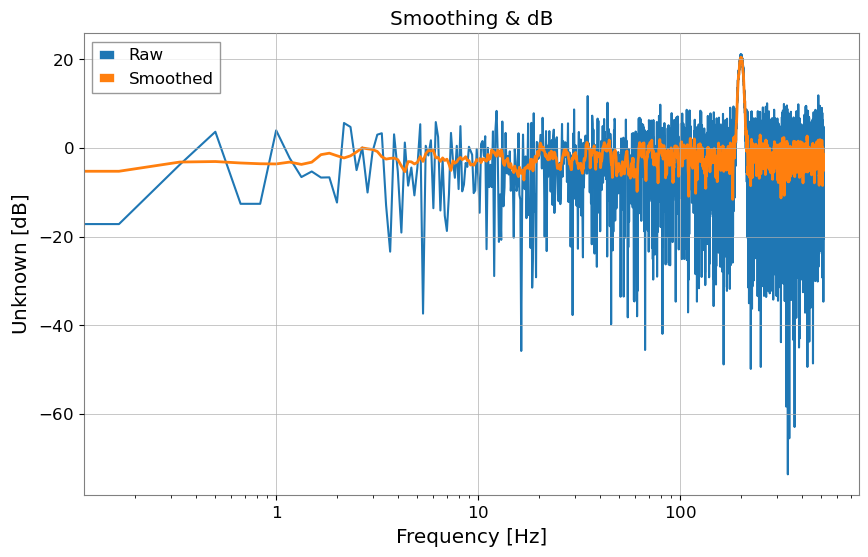

Noise A: 1.0, Noise B: 2.0
Total (Sqrt Sum): 2.23606797749979


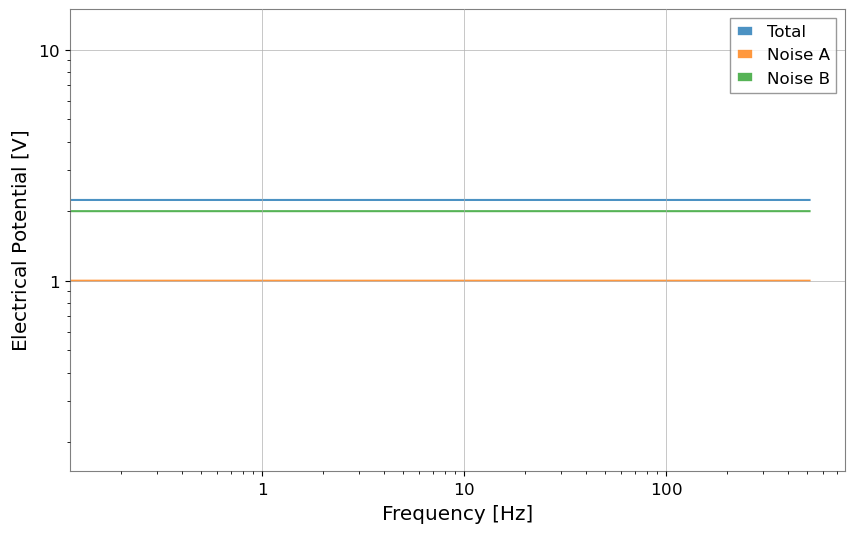

In [12]:
# Generate noisy data
np.random.seed(42)
f = spec.frequencies.value
noise = np.abs(np.random.randn(f.size))
peak = 10.0 * np.exp(-(f - 200)**2 / 50.0)
data = noise + peak

raw = FrequencySeries(data, frequencies=f, unit='V', name='Raw Data')

# Smooth
smoothed = raw.smooth(width=10, method='amplitude')
smoothed.name = 'Smoothed'

# Convert to dB
raw_db = raw.to_db()
smoothed_db = smoothed.to_db()
raw_db.name = 'Raw (dB)'
smoothed_db.name = 'Smoothed (dB)'

plot = raw_db.plot(label='Raw', title="Smoothing & dB")
ax = plot.gca()
ax.plot(smoothed_db, label='Smoothed', linewidth=2)
ax.legend()
plot.show()
plt.close()

# Quadrature Sum (Noise Budget example)
noise_a = FrequencySeries(np.ones_like(f), frequencies=f, unit='V', name='Noise A')
noise_b = FrequencySeries(np.ones_like(f) * 2, frequencies=f, unit='V', name='Noise B')

total = noise_a.quadrature_sum(noise_b)
print(f"Noise A: {noise_a.value[0]}, Noise B: {noise_b.value[0]}")
print(f"Total (Sqrt Sum): {total.value[0]}")
Plot(total, noise_a, noise_b, alpha=0.8)
plt.legend(["Total", "Noise A", "Noise B"])
plt.xscale("log")
plt.yscale("log")
plt.show()